In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

from sklearn import datasets, metrics, model_selection


In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

import datetime

log_folder = "logs/ANN/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


In [3]:
# read data

xlsx = pd.ExcelFile('./Data/Outliers_out.xlsx')
df = pd.read_excel(xlsx, '1x 5s')
dataset= df.copy()

#### Split the data into train and test

In [4]:
# the 'sample' method takes a certain fraction randomly
#Note that we use `random_state` to ensure the reproducibility of the examples.
train_dataset = dataset.sample(frac=0.7, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [5]:

# split datat into input and target

train_input = train_dataset.copy()
test_input = test_dataset.copy()

train_target = train_input.pop('RHOB')
test_target = test_input.pop('RHOB')



 normalizer = preprocessing.Normalization()

 #then adapt it to the data
 normalizer.adapt(np.array(train_input))

  #This calculates the mean and variance, and stores them in the layer.
 print(normalizer.mean.numpy())

# Create Model

In [6]:
# A function to hold preprocessor, layers, model and compiler 
def FFBackProp(inputs, output):
    #normalization
    normalizer=preprocessing.Normalization()
    #then adapt it to the data
    normalizer.adapt(np.array(inputs))
    
    
    #  Create layers
    l0=normalizer
    #Dense layers using the relu nonlinearity. #with an l2 regularization to reduce overfitting by reducing weight size
    l1=tf.keras.layers.Dense(64,activation="relu", input_shape=(5,), kernel_regularizer="l2")
    
    d0=layers.Dropout(0.1), #a droput layer # an attempt to reduce overfitting
    
    l2=tf.keras.layers.Dense(64,activation="relu", kernel_regularizer="l2")
    
    d1=layers.Dropout(0.1),
    
    #A linear output layer
    l3=tf.keras.layers.Dense(1)
    
    
#     create the model with the layers formed
    model1 =tf.keras.models.Sequential([l0,l1,d0,l2,d1,l3])
    
    
#     compile the model
    model1.compile(optimizer='adam',
                loss='mean_absolute_error', #(from_logits=True),
                metrics=["mse"]
               )
    
    model1.summary()
    
    return model1
    
myFFBP= FFBackProp(train_input,train_target)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 5)                 11        
_________________________________________________________________
dense (Dense)                (None, 64)                384       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,620
Trainable params: 4,609
Non-trainable params: 11
_________________________________________________________________


# Training

In [7]:
%%time
# tb_callback = tf.keras.callbacks.TensorBoard(log_dir="log_folder/ANN", histogram_freq=1)

tb_callback = tf.keras.callbacks.TensorBoard(log_dir=log_folder,
                                            histogram_freq=1,
                                            write_graph=True,
                                            write_images=True,
                                            update_freq='epoch',
                                            profile_batch=2,
                                            embeddings_freq=1)


myFFBPtraining = myFFBP.fit(
    train_input, train_target,
    # Calculate validation results on 30% of the training data
    validation_split=0.3,
     
    
    validation_data=(test_input, test_target)
    
    
    # suppress logging
    verbose=0,
    epochs=100,
    

    #early stopping
    #an attempt to prevent overfitting
    #the fuction to stop the trianing by tracking the validation loss
    #callbacks= keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)
    
    #to store callbacks in logs
    callbacks =[tb_callback]
)

Wall time: 20.5 s


In [8]:
myFFBP.evaluate(test_input, test_target, callbacks=[tb_callback], verbose=0, )

[0.07640989869832993, 0.009657801128923893]

In [9]:

hist = pd.DataFrame(myFFBPtraining.history)
hist['epoch'] = myFFBPtraining.epoch
hist.tail()

,loss,mse,val_loss,val_mse,epoch
95,0.073971,0.009590,0.076705,0.010224,95
96,0.074605,0.009456,0.075391,0.009689,96
97,0.074373,0.009476,0.075664,0.009912,97
98,0.073872,0.009309,0.074540,0.009459,98
99,0.073912,0.009414,0.077340,0.010073,99


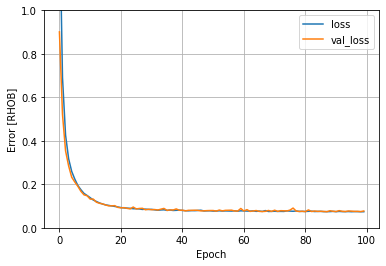

In [10]:
# a function to plot loss 
def plot_loss(arg):
  plt.plot(arg.history['loss'], label='loss')
  plt.plot(arg.history['val_loss'], label='val_loss')
  plt.ylim([0, 1])
  plt.xlabel('Epoch')
  plt.ylabel('Error [RHOB]')
  plt.legend()
  plt.grid(True)


plot_loss(myFFBPtraining)

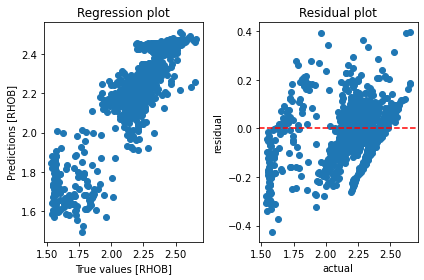

In [11]:
# Plot regression between predicted and actual (Validation)
# test_predictions = dnn_model.predict(test_input).flatten()


def plot_regre_resid(true, predicted):
    fig, (ax1,ax2)=plt.subplots(1,2)
    ax1.scatter(true, predicted)
    ax1.set_xlabel('True values [RHOB]')
    ax1.set_ylabel('Predictions [RHOB]')
    ax1.set_title("Regression plot")
#     _ = ax1.plot([0, true.max()], [0, true.max()], ls='-', color='red')

    residual = true - predicted
    ax2.scatter(true, residual)
    ax2.set_xlabel('actual')
    ax2.set_ylabel('residual')
    ax2.set_title("Residual plot")
    _ = plt.axhline(0, color='red', ls='--')
        
    plt.tight_layout()
    plt.show
    
        

test_target_actual=test_target

test_target_predicted = myFFBP.predict(test_input).flatten()
plot_regre_resid(test_target_actual,test_target_predicted)

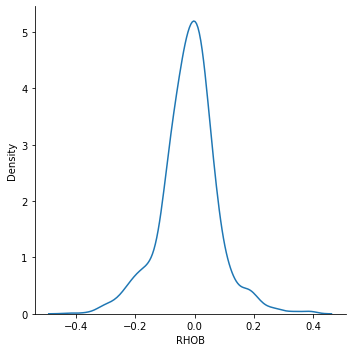

In [12]:

def plot_residual_KDE(true, predicted):
    residual = true - predicted
    _ = sns.displot(residual, kind="kde");
    
    
plot_residual_KDE(test_target_actual,test_target_predicted)

In [13]:
# using sklearn
print("r2 score: {}".format(metrics.r2_score(test_target_actual, test_target_predicted)))
print("mse: {}".format(metrics.mean_squared_error(test_target_actual, test_target_predicted)))
print("rmse: {}".format(np.sqrt(metrics.mean_squared_error(test_target_actual, test_target_predicted))))
print("mae: {}".format(metrics.mean_absolute_error(test_target_actual, test_target_predicted)))

r2 score: 0.798304432757057
mse: 0.009657800880605957
rmse: 0.09827411093775389
mae: 0.07109970869181055


# Predict a different well

In [14]:
# read different sheet from same excel book
xlsx = pd.ExcelFile('./Data/Outliers_out.xlsx')
df = pd.read_excel(xlsx, '1x 4s')
dataset2= df.copy()


# split data into input and target

inputs2 = dataset2.copy()
target2 = inputs2.pop('RHOB')

Text(0, 0.5, 'predicted')

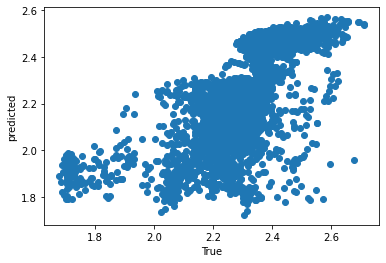

In [16]:
predicted2 = myFFBP.predict(inputs2, callbacks=[tb_callback] )
fig, ax= plt.subplots()
ax.scatter(target2,predicted2)
ax.set_xlabel("True")
ax.set_ylabel("predicted")

In [17]:
print("r2 score: {}".format(metrics.r2_score( target2, predicted2)))
print("mse: {}".format(metrics.mean_squared_error( target2, predicted2)))
print("rmse: {}".format(np.sqrt(metrics.mean_squared_error( target2, predicted2))))
print("mae: {}".format(metrics.mean_absolute_error( target2, predicted2)))

r2 score: -0.06459339602515946
mse: 0.025208412261582446
rmse: 0.15877157258647545
mae: 0.11803603278268096


Text(0.5, 0, 'RHOB')

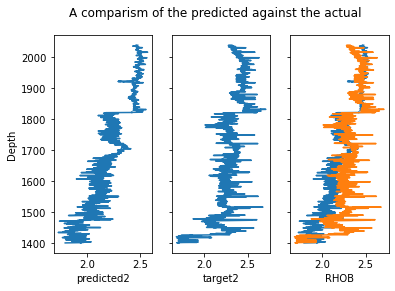

In [18]:
#plot subplots of predicted and actual
inputs2 = dataset2.copy()
Depth2= inputs2.pop("DEPTH")


fig, (ax1,ax2,ax3)=plt.subplots(1,3,sharey=True)
fig.suptitle('A comparism of the predicted against the actual')
ax1.set_ylabel("Depth")
ax1.plot(predicted2,Depth2)
ax1.set_xlabel('predicted2')

ax2.plot(target2,Depth2)
ax2.set_xlabel("target2")

ax3.plot(predicted2,Depth2)
ax3.plot(target2, Depth2)
ax3.set_xlabel("RHOB")

In [ ]:
rm -rvf logs

In [ ]:
# TENSORBOARD


In [20]:
# Load the tensorboard
%tensorboard --logdir logs/ANN/fit/
# !kill 25184
# %tensorboard -- logdir={log_folder}

# %tensorboard --logdir /cont

Reusing TensorBoard on port 6006 (pid 27656), started 0:02:04 ago. (Use '!kill 27656' to kill it.)

#  Hyperparameter Tunning

In [27]:
# clear previous log
# rm -rvf logs

# Clear any logs from previous runs
rm -rf 'logs/ANN/fit/'

SyntaxError: invalid syntax (<ipython-input-27-35595d33ceac>, line 5)

In [28]:
# help(myFFBP.evaluate)
# help(myFFBP.predict)


In [29]:
# Load the TensorBoard notebook extension
%reload_ext tensorboard

In [ ]:
# Clear any logs from previous runs
# rm -rf ./logs/

rm -rvf logs

In [31]:
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp

Experiment setup and the HParams experiment summary

Experiment with  hyperparameters in the model:

1. Number of units in the first dense layer
2. Dropout rate in the dropout layer
3. Optimizer

In [46]:
# HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([300, 200,512]))
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([16, 32]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1,0.5))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd', 'rmsprop']))

In [47]:
METRIC = "mse"

with tf.summary.create_file_writer('logs/ANN/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC, display_name='mae')],
  )

In [53]:
# Adapt TensorFlow runs to log hyperparameters and metrics

def create_model(hparams):
  model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(hparams[HP_NUM_UNITS], activation='relu'),
    tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
    tf.keras.layers.Dense(10, activation='softmax'),
  ])
  model.compile(
      optimizer=hparams[HP_OPTIMIZER],
      loss='mean_absolute_error',
      metrics=['mse'],
  )

  model.fit(train_input, train_target, epochs=5) # Run with a few epoch to speed things up for demo purposes
  loss, mse = model.evaluate(test_input, test_target)
  return loss, mse




In [54]:
# For each run, log an hparams summary with the hyperparameters and final accuracy:

def experiment(experiment_dir, hparams):
     with tf.summary.create_file_writer(experiment_dir).as_default():
        hp.hparams(hparams)
        mse = create_model(hparams)
        tf.summary.scalar(METRIC, mse, step=1)


In [55]:
experiment_no = 0

for num_units in HP_NUM_UNITS.domain.values:
    for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
        for optimizer in HP_OPTIMIZER.domain.values:
            hparams = {
                HP_NUM_UNITS: num_units,
                HP_DROPOUT: dropout_rate,
                HP_OPTIMIZER: optimizer,}

            experiment_name = f'Experiment {experiment_no}'
            print(f'Starting Experiment: {experiment_name}')
            print({h.name: hparams[h] for h in hparams})
            experiment('logs/ANN/hparam_tuning/' + experiment_name, hparams)
            experiment_no += 1

Starting Experiment: Experiment 0
{'num_units': 16, 'dropout': 0.1, 'optimizer': 'adam'}
Epoch 1/5
109/109 [==============================] - 0s 581us/step - loss: 2.1220 - mse: 4.6386
Epoch 2/5
109/109 [==============================] - 0s 545us/step - loss: 2.1230 - mse: 4.6461
Epoch 3/5
109/109 [==============================] - 0s 621us/step - loss: 2.1218 - mse: 4.6408
Epoch 4/5
109/109 [==============================] - 0s 720us/step - loss: 2.1268 - mse: 4.6604
Epoch 5/5
47/47 [==============================] - 0s 514us/step - loss: 2.1251 - mse: 4.6541


ValueError: Expected scalar shape, saw shape: (2,).

In [36]:
# import datetime

# log_folder = "logs/ANN/fit/Hparams" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# logdirHparams=log_folder



In [37]:
log_dir=log_folder,

model.fit(
    ...,
    callbacks=[
        tf.keras.callbacks.TensorBoard(logdirHparams),  # log metrics
        hp.KerasCallback(logdirHparams, hparams),  # log hparams
    ],
)

NameError: name 'model' is not defined

In [ ]:
4. Visualize the results in TensorBoard's HParams plugin

In [39]:
%tensorboard --logdir logs/hparam_tuning

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 27188.